In [2]:
!pip install rouge-score 

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c4e4dc2c6569ceee4a81bf33b0b5410fcd1129783720e7e5344d94f86bb1c5d4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


FORM DATASTET

In [3]:
import pandas as pd
import json
import os
import numpy as np
from rouge_score import rouge_scorer
import re
import glob
from PIL import Image, ImageEnhance
import torch
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
import time
import gc
import matplotlib.pyplot as plt



# Configuration
class CFG:
    model_name = "/kaggle/input/qwen2-vl/transformers/7b-instruct/1"  # Update this path to your model location
    image_dir = '/kaggle/input/form-ocr-dataset-1/training_data/images'  # Update to your image directory
    annotation_dir = '/kaggle/input/form-ocr-dataset-1/training_data/annotations'  # Update to your annotation directory
    num_images = 50
    output_csv = 'qwen_ocr_results.csv'
    enhance_contrast = True  # Set to True to enhance image contrast
    contrast_factor = 2.0  # Contrast enhancement factor

# Load model only once
def build_model():
    print('Loading Qwen-2VL model...')
    
    processor = AutoProcessor.from_pretrained(CFG.model_name)
    
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        CFG.model_name,
        torch_dtype="auto",
        device_map="auto",
    )
    
    return processor, model

# Process single image using Qwen-2VL
def process_image(image_path, processor, model):
    try:
        # Load and preprocess image
        image = Image.open(image_path)
        
        # Convert to RGB if not already
        if image.mode != 'RGB':
            print(f"Converting {image.mode} image to RGB")
            image = image.convert('RGB')
        
        # Enhance contrast if enabled
        if CFG.enhance_contrast:
            image = ImageEnhance.Contrast(image).enhance(CFG.contrast_factor)
        
        # Start timing
        start_time = time.time()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        
        # Prepare input in the Qwen chat format
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Extract all the text in this image."}
                ]
            }
        ]
        
        inputs = processor(
            text=processor.apply_chat_template(messages, add_generation_prompt=True),
            images=[image],
            padding=True,
            return_tensors="pt"
        )
        
        # Move inputs to device
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate text
        output_ids = model.generate(**inputs, max_new_tokens=1024)
        
        # Decode output
        extracted_text = processor.batch_decode(
            output_ids, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=True
        )[0]
        
        # Get metrics
        inference_time = time.time() - start_time
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 2) if torch.cuda.is_available() else 0  # MB
        
        # Clean up
        del inputs, output_ids
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        
        # Optional: display the image and extracted text (useful for debugging)
        if False:  # Set to True if you want to see the images during processing
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            plt.axis("off")
            plt.title("Processed Image")
            plt.show()
            print(f"Extracted Text: {extracted_text}")
        
        return extracted_text, inference_time, max_memory
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None, None

# Main processing function for OCR
def process_ocr():
    # Get images
    all_images = sorted([
        os.path.join(CFG.image_dir, f) 
        for f in os.listdir(CFG.image_dir) 
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])[:CFG.num_images]
    
    print(f"Found {len(all_images)} images to process")
    
    # Load model once
    processor, model = build_model()
    
    results = []
    
    for idx, img_path in enumerate(all_images, 1):
        img_filename = os.path.basename(img_path)
        print(f"Processing image {idx}/{len(all_images)}: {img_filename}")
        
        ocr_text, inf_time, mem_usage = process_image(img_path, processor, model)
        
        results.append({
            'image_id': img_filename,
            'ocr_text': ocr_text,
            'inference_time_sec': inf_time,
            'gpu_memory_usage_mb': mem_usage
        })
    
    # Save results
    df = pd.DataFrame(results)
    df.to_csv(CFG.output_csv, index=False)
    print(f"Results saved to {CFG.output_csv}")
    
    return df

# Function to extract all text from annotation file
def extract_text_from_annotation(annotation_file):
    try:
        with open(annotation_file, 'r') as f:
            data = json.load(f)
        
        # Your annotation format has a list of text entries
        all_texts = []
        
        # Extract text from each item in the list
        if isinstance(data, list):
            for item in data:
                if 'text' in item:
                    all_texts.append(item['text'])
        # If the data is a dictionary with a list under a key like 'annotations'
        elif isinstance(data, dict):
            for key in data:
                if isinstance(data[key], list):
                    for item in data[key]:
                        if isinstance(item, dict) and 'text' in item:
                            all_texts.append(item['text'])
        
        # Join all the text pieces
        return " ".join(all_texts)
    except Exception as e:
        print(f"Error extracting text from {annotation_file}: {e}")
        return ""

# Function to clean text for ROUGE comparison
def clean_text(text):
    if text is None or text == "None":
        return ""
    # Remove extra whitespace, newlines and normalize
    return re.sub(r'\s+', ' ', str(text)).strip()

# Main function to calculate ROUGE scores
def calculate_rouge():
    # Load OCR results
    ocr_results_df = pd.read_csv(CFG.output_csv)
    print(f"Loaded {len(ocr_results_df)} OCR results")
    
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    rouge_scores = []
    
    # Process each image that has OCR results
    for _, row in ocr_results_df.iterrows():
        image_filename = row['image_id']
        ocr_text = clean_text(row['ocr_text'])
        
        # Skip if OCR failed
        if not ocr_text:
            print(f"Skipping {image_filename} - No OCR text available")
            continue
        
        # Find corresponding annotation file
        base_name = os.path.splitext(image_filename)[0]
        annotation_path = os.path.join(CFG.annotation_dir, f"{base_name}.json")
        
        if not os.path.exists(annotation_path):
            print(f"No annotation found for {image_filename}")
            continue
        
        # Extract text from annotation
        ground_truth = extract_text_from_annotation(annotation_path)
        ground_truth = clean_text(ground_truth)
        
        if not ground_truth:
            print(f"Empty ground truth for {image_filename}")
            continue
        
        # Calculate ROUGE scores
        scores = scorer.score(ground_truth, ocr_text)
        
        rouge_scores.append({
            'image_file': image_filename,
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
            'ground_truth_length': len(ground_truth),
            'ocr_text_length': len(ocr_text),
            'ground_truth': ground_truth[:500] + "..." if len(ground_truth) > 500 else ground_truth,
            'ocr_text': ocr_text[:500] + "..." if len(ocr_text) > 500 else ocr_text
        })
        
        print(f"Calculated ROUGE for {image_filename}")
    
    # Save ROUGE scores to JSON
    with open('qwen_rouge_scores.json', 'w') as f:
        json.dump(rouge_scores, f, indent=4)
    
    # Calculate and print average scores
    if rouge_scores:
        avg_scores = {
            'model': 'Qwen-2VL',
            'avg_rouge1_precision': np.mean([s['rouge1_precision'] for s in rouge_scores]),
            'avg_rouge1_recall': np.mean([s['rouge1_recall'] for s in rouge_scores]),
            'avg_rouge1_f1': np.mean([s['rouge1_f1'] for s in rouge_scores]),
            'avg_rouge2_precision': np.mean([s['rouge2_precision'] for s in rouge_scores]),
            'avg_rouge2_recall': np.mean([s['rouge2_recall'] for s in rouge_scores]),
            'avg_rouge2_f1': np.mean([s['rouge2_f1'] for s in rouge_scores]),
            'avg_rougeL_precision': np.mean([s['rougeL_precision'] for s in rouge_scores]),
            'avg_rougeL_recall': np.mean([s['rougeL_recall'] for s in rouge_scores]),
            'avg_rougeL_f1': np.mean([s['rougeL_f1'] for s in rouge_scores]),
            'num_images_processed': len(rouge_scores)
        }
        
        print("\nAverage ROUGE Scores for Qwen-2VL:")
        for metric, value in avg_scores.items():
            if isinstance(value, float):
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")
        
        # Save summary
        with open('qwen_rouge_scores_summary.json', 'w') as f:
            json.dump(avg_scores, f, indent=4)
        
        # Create sorted lists for best/worst performing images
        sorted_by_f1 = sorted(rouge_scores, key=lambda x: x['rougeL_f1'], reverse=True)
        
        print("\nTop 5 images by ROUGE-L F1 score:")
        for i, score in enumerate(sorted_by_f1[:5]):
            print(f"{i+1}. {score['image_file']} - ROUGE-L F1: {score['rougeL_f1']:.4f}")
        
        print("\nBottom 5 images by ROUGE-L F1 score:")
        for i, score in enumerate(sorted_by_f1[-5:]):
            print(f"{i+1}. {score['image_file']} - ROUGE-L F1: {score['rougeL_f1']:.4f}")
        
        return avg_scores
    else:
        print("No ROUGE scores calculated. Check your OCR results and annotation files.")
        return None

# Compare results between Florence and Qwen models
def compare_models():
    try:
        # Load Florence results
        with open('rouge_scores_summary.json', 'r') as f:
            florence_scores = json.load(f)
        
        # Load Qwen results
        with open('qwen_rouge_scores_summary.json', 'r') as f:
            qwen_scores = json.load(f)
        
        # Add model names
        florence_scores['model'] = 'Florence-2'
        
        # Print comparison
        print("\n===== MODEL COMPARISON =====")
        metrics = [
            'avg_rouge1_precision', 'avg_rouge1_recall', 'avg_rouge1_f1',
            'avg_rouge2_precision', 'avg_rouge2_recall', 'avg_rouge2_f1',
            'avg_rougeL_precision', 'avg_rougeL_recall', 'avg_rougeL_f1'
        ]
        
        print(f"{'Metric':<25} {'Florence-2':<15} {'Qwen-2VL':<15} {'Difference':<15}")
        print('-' * 70)
        
        for metric in metrics:
            florence_val = florence_scores.get(metric, 0)
            qwen_val = qwen_scores.get(metric, 0)
            diff = qwen_val - florence_val
            diff_str = f"{diff:.4f} ({'+' if diff > 0 else ''}{diff/florence_val*100:.2f}%)" if florence_val else "N/A"
            
            print(f"{metric:<25} {florence_val:.4f} {qwen_val:.4f} {diff_str:<15}")
        
        # Save comparison
        comparison = {
            'florence': florence_scores,
            'qwen': qwen_scores,
            'metrics_compared': metrics,
            'differences': {metric: qwen_scores.get(metric, 0) - florence_scores.get(metric, 0) for metric in metrics}
        }
        
        with open('model_comparison.json', 'w') as f:
            json.dump(comparison, f, indent=4)
            
        print("\nComparison saved to model_comparison.json")
            
    except Exception as e:
        print(f"Error comparing models: {e}")

# Main execution
if __name__ == "__main__":
    # Process images with OCR using Qwen model
    process_ocr()
    
    # Calculate ROUGE scores
    calculate_rouge()
    


2025-05-20 15:02:23.128358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747753343.361137      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747753343.427736      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found 50 images to process
Loading Qwen-2VL model...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing image 1/50: 0000971160.png
Converting L image to RGB
Processing image 2/50: 0000989556.png
Converting L image to RGB
Processing image 3/50: 0000990274.png
Converting L image to RGB
Processing image 4/50: 0000999294.png
Converting L image to RGB
Processing image 5/50: 0001118259.png
Converting L image to RGB
Processing image 6/50: 0001123541.png
Converting L image to RGB
Processing image 7/50: 0001129658.png
Converting L image to RGB
Processing image 8/50: 0001209043.png
Converting L image to RGB
Processing image 9/50: 0001239897.png
Converting L image to RGB
Processing image 10/50: 0001438955.png
Converting L image to RGB
Processing image 11/50: 0001456787.png
Converting L image to RGB
Processing image 12/50: 0001463282.png
Converting L image to RGB
Processing image 13/50: 0001463448.png
Converting L image to RGB
Processing image 14/50: 0001476912.png
Converting L image to RGB
Processing image 15/50: 0001477983.png
Converting L image to RGB
Processing image 16/50: 0001485288

RECEIPTS DATASET

In [4]:
!pip install rouge_score
import os
import gc
import time
import json
import xml.etree.ElementTree as ET
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import re
import subprocess
import psutil

# First, check and install required packages


# Configuration class
class CFG:
    # Model
    model_name = "/kaggle/input/qwen2-vl/transformers/7b-instruct/1"
    max_tokens = 1024
    contrast_factor = 2.0  # Enhance image contrast
    
    # Input data
    image_root = '/kaggle/input/ocr-receipts-text-detection/images'
    annotation_file = '/kaggle/input/ocr-receipts-text-detection/annotations.xml'
    
    # Output data
    output_path = "./qwen2_vl_results.json"
    
    # Process all images by default
    process_all = True

def get_memory_usage():
    """Get current memory usage of the process"""
    try:
        process = psutil.Process(os.getpid())
        memory_info = process.memory_info()
        return {
            'rss': memory_info.rss / (1024 * 1024),  # RSS in MB
            'vms': memory_info.vms / (1024 * 1024)   # VMS in MB
        }
    except:
        return {'rss': 0, 'vms': 0}

def build_model():
    """Build Qwen-2-VL model"""
    print(f'\nLoading model from: {CFG.model_name}\n')
    
    # Import required modules
    from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
    
    # Load model and processor
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        CFG.model_name,
        torch_dtype="auto",
        device_map="auto",
    )
    
    processor = AutoProcessor.from_pretrained(CFG.model_name)
    
    device = next(model.parameters()).device
    print(f"Model loaded successfully on device: {device}")
    
    return processor, model

def inference(image, model, processor):
    """Run inference with Qwen-2-VL model"""
    start_time = time.time()
    
    try:
        # Enhance image contrast
        enhanced_image = ImageEnhance.Contrast(image).enhance(CFG.contrast_factor).convert("RGB")
        
        # Create messages for the model
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Extract all the text from this receipt image. Include all items, prices, totals, and the store name."}
                ]
            }
        ]
        
        # Process input
        inputs = processor(
            text=processor.apply_chat_template(messages, add_generation_prompt=True),
            images=[enhanced_image],
            padding=True,
            return_tensors="pt"
        )
        
        # Move inputs to device
        inputs = inputs.to(model.device)
        
        # Generate output
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=CFG.max_tokens)
        
        # Decode output
        extracted_text = processor.batch_decode(
            output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )[0]
        
        # Extract only the model's response (remove prompts)
        try:
            # Check if there's an "ASSISTANT:" prefix in the output
            if "ASSISTANT:" in extracted_text:
                result = extracted_text.split("ASSISTANT:", 1)[1].strip()
            else:
                result = extracted_text
        except:
            result = extracted_text
    
    except Exception as e:
        print(f"Error during inference: {str(e)}")
        result = f"Error: {str(e)}"
    
    # Calculate runtime
    inference_time = time.time() - start_time
    
    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    # Return results and metrics
    return {
        'result': result,
        'inference_time': inference_time
    }

def parse_annotations(xml_file):
    """Parse annotations from XML file"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    annotations = {}
    
    # Process each image
    for image in root.findall('.//image'):
        img_id = int(image.get('id'))
        img_name = image.get('name').split('/')[-1]
        
        # Extract annotations for this image
        boxes = []
        for box in image.findall('.//box'):
            label_type = box.get('label')
            text = box.find('.//attribute[@name="text"]')
            
            if text is not None and text.text is not None:
                boxes.append({
                    'label': label_type,
                    'text': text.text
                })
        
        # Store annotations
        annotations[img_id] = {
            'filename': img_name,
            'boxes': boxes
        }
    
    return annotations

def normalize_text(text):
    """Normalize text for better ROUGE matching"""
    # Convert to lowercase
    text = text.lower()
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Remove non-alphanumeric chars except spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Trim leading/trailing spaces
    text = text.strip()
    return text

def calculate_rouge_scores(predicted_text, reference_boxes):
    """Calculate ROUGE scores between prediction and references"""
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Combine all reference texts
    all_text = ' '.join([box['text'] for box in reference_boxes])
    normalized_reference = normalize_text(all_text)
    
    # Normalize predicted text
    normalized_prediction = normalize_text(predicted_text)
    
    # Calculate scores
    scores = scorer.score(normalized_reference, normalized_prediction)
    
    # Calculate per-label scores
    per_label_scores = {}
    for label_type in set(box['label'] for box in reference_boxes):
        # Get text for this label type
        label_text = ' '.join([box['text'] for box in reference_boxes if box['label'] == label_type])
        normalized_label_text = normalize_text(label_text)
        
        # Calculate scores for this label
        label_scores = scorer.score(normalized_label_text, normalized_prediction)
        per_label_scores[label_type] = {
            'rouge1': label_scores['rouge1'].fmeasure,
            'rouge2': label_scores['rouge2'].fmeasure,
            'rougeL': label_scores['rougeL'].fmeasure
        }
    
    # Debug info
    debug_info = {
        'reference_sample': normalized_reference[:100] + "..." if len(normalized_reference) > 100 else normalized_reference,
        'prediction_sample': normalized_prediction[:100] + "..." if len(normalized_prediction) > 100 else normalized_prediction,
        'reference_length': len(normalized_reference),
        'prediction_length': len(normalized_prediction)
    }
    
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure,
        'per_label': per_label_scores,
        'debug': debug_info
    }

def main():
    # Load annotations
    annotations = parse_annotations(CFG.annotation_file)
    print(f"Loaded annotations for {len(annotations)} images")
    
    # Build model
    processor, model = build_model()
    
    results = []
    
    # Process images - either all or just first 3
    if CFG.process_all:
        test_img_ids = list(annotations.keys())
    else:
        test_img_ids = list(annotations.keys())[:3]
    
    print(f"Processing {len(test_img_ids)} images")
    
    # Process each image
    for img_id in test_img_ids:
        annotation = annotations[img_id]
        print(f"\nProcessing image {img_id}: {annotation['filename']}")
        
        # Display annotation summary
        print(f"Annotations: {len(annotation['boxes'])} boxes")
        for i, box in enumerate(annotation['boxes']):
            if i < 3 or i == len(annotation['boxes']) - 1:  # Show first 3 and last annotation
                print(f"  {box['label']}: {box['text']}")
            elif i == 3:
                print(f"  ... ({len(annotation['boxes']) - 4} more) ...")
        
        # Load image
        img_path = os.path.join(CFG.image_root, annotation['filename'])
        
        try:
            # Try loading with PIL directly first
            pil_image = Image.open(img_path)
        except:
            # Fallback to OpenCV
            image = cv2.imread(img_path)
            if image is None:
                print(f"Image {img_path} not found. Skipping.")
                continue
                
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(image_rgb)
        
        # Run OCR inference
        print("Running OCR extraction...")
        ocr_result = inference(image=pil_image, model=model, processor=processor)
        
        # Print OCR result preview
        print("\nOCR Result Preview:")
        preview = ocr_result['result'][:150] + "..." if len(ocr_result['result']) > 150 else ocr_result['result']
        print(preview)
        
        # Calculate ROUGE scores
        print("\nCalculating ROUGE scores...")
        rouge_scores = calculate_rouge_scores(ocr_result['result'], annotation['boxes'])
        
        print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
        
        # Print per-label scores
        print("\nPer-label ROUGE-1 scores:")
        for label, scores in rouge_scores['per_label'].items():
            print(f"  {label}: {scores['rouge1']:.4f}")
        
        # Store results
        results.append({
            'image_id': img_id,
            'filename': annotation['filename'],
            'ocr_result': ocr_result['result'],
            'ground_truth': [box['text'] for box in annotation['boxes']],
            'rouge_scores': rouge_scores,
            'inference_time': ocr_result['inference_time']
        })
        
        # Save intermediate results
        with open(CFG.output_path, 'w') as f:
            json.dump({
                'model': CFG.model_name,
                'results': results
            }, f, indent=2)
    
    print(f"\nEvaluation complete. Results saved to {CFG.output_path}")
    
    # Calculate average scores
    if results:
        avg_rouge1 = sum(r['rouge_scores']['rouge1'] for r in results) / len(results)
        avg_rouge2 = sum(r['rouge_scores']['rouge2'] for r in results) / len(results)
        avg_rougeL = sum(r['rouge_scores']['rougeL'] for r in results) / len(results)
        avg_time = sum(r['inference_time'] for r in results) / len(results)
        
        print("\nAverage ROUGE Scores:")
        print(f"  ROUGE-1: {avg_rouge1:.4f}")
        print(f"  ROUGE-2: {avg_rouge2:.4f}")
        print(f"  ROUGE-L: {avg_rougeL:.4f}")
        print(f"Average inference time: {avg_time:.2f} seconds")
        
        # Per-label average scores
        print("\nAverage ROUGE-1 per label:")
        label_types = set()
        for r in results:
            label_types.update(r['rouge_scores']['per_label'].keys())
        
        label_avg_scores = {}
        for label in label_types:
            scores = [r['rouge_scores']['per_label'][label]['rouge1'] 
                     for r in results 
                     if label in r['rouge_scores']['per_label']]
            if scores:
                avg_score = sum(scores) / len(scores)
                print(f"  {label}: {avg_score:.4f} (from {len(scores)} images)")
                label_avg_scores[label] = avg_score
        
        # Save summary
        with open("qwen2_vl_summary.json", 'w') as f:
            json.dump({
                'model': CFG.model_name,
                'num_images_processed': len(results),
                'avg_rouge1': avg_rouge1,
                'avg_rouge2': avg_rouge2,
                'avg_rougeL': avg_rougeL,
                'avg_inference_time': avg_time,
                'per_label_avg_scores': label_avg_scores
            }, f, indent=2)
        
        print(f"\nSummary saved to qwen2_vl_summary.json")

if __name__ == "__main__":
    main()

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=afb0789f9f775a639dc1953f46430a5d9843ed9e7912e46b998376fb2c980e68
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Loaded annotations for 20 images

Loading model from: /kaggle/input/qwen2-vl/transformers/7b-instruct/1



Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully on device: cuda:0
Processing 20 images

Processing image 0: 0.jpg
Annotations: 5 boxes
  shop: WALMART
  total: TOTAL 5.11
  item: FRAP 001200010451 F 5.48 N
  ... (1 more) ...
  date_time: 08/20/10 13:12:01
Running OCR extraction...

OCR Result Preview:
system
You are a helpful assistant.
user
Extract all the text from this receipt image. Include all items, prices, totals, and the store name.
assistan...

Calculating ROUGE scores...
ROUGE-1: 0.2975
ROUGE-2: 0.2017
ROUGE-L: 0.1818

Per-label ROUGE-1 scores:
  item: 0.2241
  total: 0.0385
  shop: 0.0194
  date_time: 0.0385

Processing image 1: 1.jpg
Annotations: 21 boxes
  total: TOTAL $38.68
  item: MINI-PEARL TOMATOES.. 2.49
  item: PKG SHREDDED MOZZARELLA LITE T 3.99
  ... (17 more) ...
  item: ORGANIC OLD FASHIONED OATMEAL 2.69
Running OCR extraction...

OCR Result Preview:
system
You are a helpful assistant.
user
Extract all the text from this receipt image. Include all items, prices, totals, and the store

BOTH HANDWRITTEN DATASET

2025-05-21 00:57:44.961879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747789065.398135      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747789065.513354      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading model from: /kaggle/input/qwen2-vl/transformers/7b-instruct/1
Loaded test image: /kaggle/input/ocr-receipts-text-detection/images/1.jpg, size: (688, 1024)
Baseline GPU Memory: 0.00 MB allocated, 0.00 MB reserved
After loading processor: 0.00 MB allocated, 0.00 MB reserved


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

After loading model: 7218.16 MB allocated, 7222.00 MB reserved
Model size in memory: 7218.16 MB

Run 1/3
Memory for input processing: 16.61 MB
Memory for generation: 8.14 MB
Total memory increase: 24.75 MB
Peak memory: 7546.70 MB
Inference time: 36.23 seconds

Run 2/3
Memory for input processing: 0.00 MB
Memory for generation: 0.00 MB
Total memory increase: 0.00 MB
Peak memory: 7546.71 MB
Inference time: 33.35 seconds

Run 3/3
Memory for input processing: 0.00 MB
Memory for generation: 0.00 MB
Total memory increase: 0.00 MB
Peak memory: 7546.71 MB
Inference time: 33.36 seconds

Average across runs:
Input processing memory: 5.54 MB
Generation memory: 2.71 MB
Total memory increase: 8.25 MB
Peak memory: 7546.71 MB
Inference time: 34.31 seconds
Results saved to memory_analysis_results.json
Memory usage plot saved to memory_usage.png
Memory by stage plot saved to memory_by_stage.png


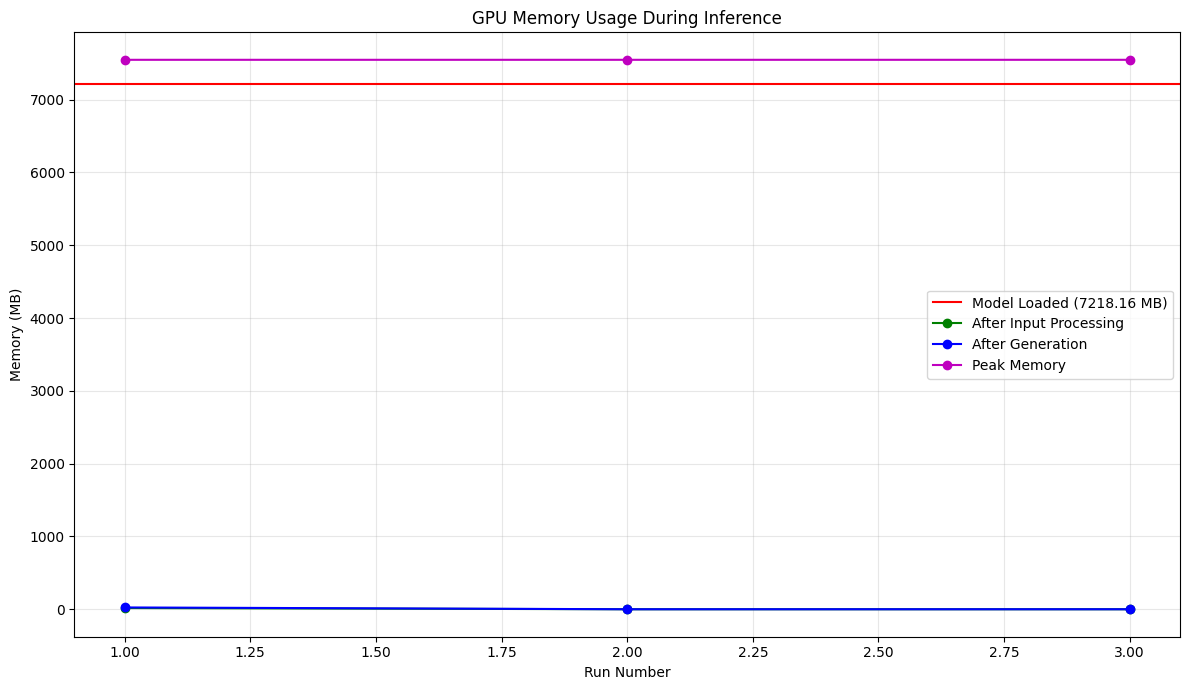

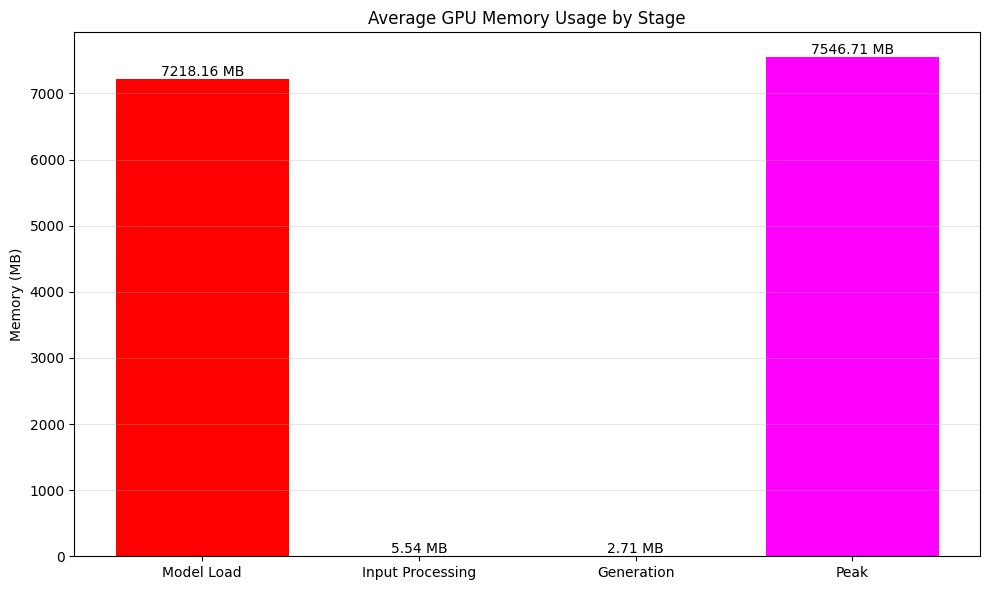

In [1]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration

# Configuration
class CFG:
    # Model paths
    qwen_model_path = "/kaggle/input/qwen2-vl/transformers/7b-instruct/1"
    
    # Test image path - adjust if needed
    test_image_path = "/kaggle/input/ocr-receipts-text-detection/images/1.jpg"
    
    # Output file
    output_file = "memory_analysis_results.json"
    
    # Number of test runs
    num_runs = 3
    
    # Maximum new tokens for generation
    max_tokens = 1024

def get_gpu_memory_info():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        # Get current device
        device = torch.cuda.current_device()
        
        # Get memory information
        mem_info = {
            'allocated': torch.cuda.memory_allocated(device) / (1024 * 1024),  # MB
            'reserved': torch.cuda.memory_reserved(device) / (1024 * 1024),    # MB
            'max_allocated': torch.cuda.max_memory_allocated(device) / (1024 * 1024),  # MB
            'max_reserved': torch.cuda.max_memory_reserved(device) / (1024 * 1024),   # MB
            'total': torch.cuda.get_device_properties(device).total_memory / (1024 * 1024)  # MB
        }
        
        # Get memory stats for each tensor
        if hasattr(torch.cuda, 'memory_stats'):
            mem_info['stats'] = {k: v / (1024 * 1024) for k, v in torch.cuda.memory_stats().items()}
            
        # Get memory summary
        if hasattr(torch.cuda, 'memory_summary'):
            mem_info['summary'] = torch.cuda.memory_summary()
            
        return mem_info
    else:
        return None

def measure_model_memory(model_path, test_image_path, num_runs=3, max_tokens=1024):
    """Measure memory usage of a model during inference"""
    results = {
        'model': model_path,
        'device': "CPU" if not torch.cuda.is_available() else f"GPU:{torch.cuda.get_device_name(0)}",
        'runs': []
    }
    
    print(f"Loading model from: {model_path}")
    
    # Check if CUDA is available
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, using CPU only. Memory measurements will be minimal.")
        return results
    
    # Load test image
    try:
        test_image = Image.open(test_image_path)
        print(f"Loaded test image: {test_image_path}, size: {test_image.size}")
    except Exception as e:
        print(f"Error loading test image: {e}")
        return results
    
    # Reset CUDA memory stats
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    
    # Baseline memory before loading model
    baseline_memory = get_gpu_memory_info()
    results['baseline_memory'] = baseline_memory
    print(f"Baseline GPU Memory: {baseline_memory['allocated']:.2f} MB allocated, {baseline_memory['reserved']:.2f} MB reserved")
    
    try:
        # Load processor
        processor = AutoProcessor.from_pretrained(model_path)
        
        # After processor memory
        processor_memory = get_gpu_memory_info()
        results['processor_memory'] = processor_memory
        print(f"After loading processor: {processor_memory['allocated']:.2f} MB allocated, {processor_memory['reserved']:.2f} MB reserved")
        
        # Load model
        model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map="auto",
        )
        
        # After model memory
        model_memory = get_gpu_memory_info()
        results['model_memory'] = model_memory
        print(f"After loading model: {model_memory['allocated']:.2f} MB allocated, {model_memory['reserved']:.2f} MB reserved")
        print(f"Model size in memory: {model_memory['allocated'] - processor_memory['allocated']:.2f} MB")
        
        # Create messages for the model
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Extract all the text from this receipt image."}
                ]
            }
        ]
        
        # Run inference multiple times and measure memory
        for run in range(num_runs):
            print(f"\nRun {run+1}/{num_runs}")
            
            # Reset peak stats
            torch.cuda.reset_peak_memory_stats()
            
            # Before inference memory
            before_memory = get_gpu_memory_info()
            
            # Process input
            start_time = time.time()
            inputs = processor(
                text=processor.apply_chat_template(messages, add_generation_prompt=True),
                images=[test_image],
                padding=True,
                return_tensors="pt"
            )
            
            # Move inputs to device
            inputs = inputs.to(model.device)
            
            # After input processing memory
            input_memory = get_gpu_memory_info()
            
            # Generate output
            with torch.no_grad():
                try:
                    output_ids = model.generate(**inputs, max_new_tokens=max_tokens)
                    # Memory after generation
                    generation_memory = get_gpu_memory_info()
                    
                    # Decode output (this shouldn't use much CUDA memory)
                    _ = processor.batch_decode(
                        output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
                    )[0]
                    
                    inference_time = time.time() - start_time
                    
                    # Final memory after full inference
                    after_memory = get_gpu_memory_info()
                    
                    run_results = {
                        'run_id': run + 1,
                        'before_memory': before_memory,
                        'input_memory': input_memory,
                        'generation_memory': generation_memory,
                        'after_memory': after_memory,
                        'inference_time': inference_time,
                        'memory_increase': {
                            'input_processing': input_memory['allocated'] - before_memory['allocated'],
                            'generation': generation_memory['allocated'] - input_memory['allocated'],
                            'total': after_memory['allocated'] - before_memory['allocated']
                        },
                        'peak_memory': after_memory['max_allocated']
                    }
                    
                    results['runs'].append(run_results)
                    
                    print(f"Memory for input processing: {run_results['memory_increase']['input_processing']:.2f} MB")
                    print(f"Memory for generation: {run_results['memory_increase']['generation']:.2f} MB")
                    print(f"Total memory increase: {run_results['memory_increase']['total']:.2f} MB")
                    print(f"Peak memory: {run_results['peak_memory']:.2f} MB")
                    print(f"Inference time: {inference_time:.2f} seconds")
                    
                except Exception as e:
                    print(f"Error during generation: {e}")
                    results['runs'].append({
                        'run_id': run + 1,
                        'error': str(e),
                        'before_memory': before_memory
                    })
            
            # Clear CUDA cache between runs
            torch.cuda.empty_cache()
            time.sleep(1)  # Small pause to let memory fully clear
    
    except Exception as e:
        print(f"Error in memory measurement: {e}")
        results['error'] = str(e)
    
    # Calculate average memory usage across runs
    if results['runs']:
        valid_runs = [r for r in results['runs'] if 'error' not in r]
        if valid_runs:
            results['average'] = {
                'input_processing_memory': np.mean([r['memory_increase']['input_processing'] for r in valid_runs]),
                'generation_memory': np.mean([r['memory_increase']['generation'] for r in valid_runs]),
                'total_memory_increase': np.mean([r['memory_increase']['total'] for r in valid_runs]),
                'peak_memory': np.mean([r['peak_memory'] for r in valid_runs]),
                'inference_time': np.mean([r['inference_time'] for r in valid_runs])
            }
            
            print("\nAverage across runs:")
            print(f"Input processing memory: {results['average']['input_processing_memory']:.2f} MB")
            print(f"Generation memory: {results['average']['generation_memory']:.2f} MB")
            print(f"Total memory increase: {results['average']['total_memory_increase']:.2f} MB")
            print(f"Peak memory: {results['average']['peak_memory']:.2f} MB")
            print(f"Inference time: {results['average']['inference_time']:.2f} seconds")
    
    return results

def plot_memory_usage(results, output_path="memory_usage.png"):
    """Create a visualization of memory usage"""
    valid_runs = [r for r in results['runs'] if 'error' not in r]
    if not valid_runs:
        print("No valid runs to plot")
        return
    
    # Extract relevant memory data
    run_ids = [r['run_id'] for r in valid_runs]
    baseline = results['baseline_memory']['allocated'] if 'baseline_memory' in results else 0
    model_load = results['model_memory']['allocated'] if 'model_memory' in results else 0
    input_proc = [baseline + r['memory_increase']['input_processing'] for r in valid_runs]
    generation = [baseline + r['memory_increase']['input_processing'] + r['memory_increase']['generation'] for r in valid_runs]
    peak = [r['peak_memory'] for r in valid_runs]
    
    # Plotting
    plt.figure(figsize=(12, 7))
    
    # Model loading memory (constant across runs)
    plt.axhline(y=model_load, color='r', linestyle='-', label=f'Model Loaded ({model_load:.2f} MB)')
    
    # Memory used in each stage
    plt.plot(run_ids, input_proc, 'go-', label='After Input Processing')
    plt.plot(run_ids, generation, 'bo-', label='After Generation')
    plt.plot(run_ids, peak, 'mo-', label='Peak Memory')
    
    plt.xlabel('Run Number')
    plt.ylabel('Memory (MB)')
    plt.title('GPU Memory Usage During Inference')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Memory usage plot saved to {output_path}")
    
    # Also create a bar chart for average memory
    avg = results['average']
    plt.figure(figsize=(10, 6))
    
    stages = ['Model Load', 'Input Processing', 'Generation', 'Peak']
    memory_values = [
        model_load - baseline,
        avg['input_processing_memory'],
        avg['generation_memory'],
        avg['peak_memory'] - baseline
    ]
    
    plt.bar(stages, memory_values, color=['red', 'green', 'blue', 'magenta'])
    plt.ylabel('Memory (MB)')
    plt.title('Average GPU Memory Usage by Stage')
    
    # Add values on top of bars
    for i, v in enumerate(memory_values):
        plt.text(i, v + 50, f"{v:.2f} MB", ha='center')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("memory_by_stage.png")
    print("Memory by stage plot saved to memory_by_stage.png")

def main():
    # Run memory analysis
    results = measure_model_memory(
        model_path=CFG.qwen_model_path,
        test_image_path=CFG.test_image_path,
        num_runs=CFG.num_runs,
        max_tokens=CFG.max_tokens
    )
    
    # Save results
    with open(CFG.output_file, 'w') as f:
        # Need to convert some types that aren't JSON serializable
        cleaned_results = json.loads(
            json.dumps(results, default=lambda o: str(o) if isinstance(o, (torch.device, type)) else o)
        )
        json.dump(cleaned_results, f, indent=2)
    
    print(f"Results saved to {CFG.output_file}")
    
    # Plot results
    if 'runs' in results and results['runs']:
        plot_memory_usage(results)

if __name__ == "__main__":
    main()

In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=eb1eeb612cc628bd70e519c450054fab0d355ff89aca69904a2d8cc2293def27
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [2]:
import os
import gc
import time
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from rouge_score import rouge_scorer
import re
import subprocess
import psutil
import pandas as pd

# Configuration class
class CFG:
    # Model
    model_name = "/kaggle/input/qwen2-vl/transformers/7b-instruct/1"
    max_tokens = 1024
    contrast_factor = 2.0  # Enhance image contrast
    
    # Dataset paths
    receipt_dir = "/kaggle/input/handwritten-data-form-receipts/receipts/receipts"  # Folder with receipt images and txt files
    form_dir = "/kaggle/input/handwritten-data-form-receipts/forms/forms"        # Folder with form images and txt files
    
    # Output data
    output_dir = "./qwen_results"
    receipt_output = "qwen_receipt_results.json"
    form_output = "qwen_form_results.json"
    summary_output = "qwen_summary.json"
    
    # Image formats to process
    img_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']

def get_memory_usage():
    """Get current memory usage of the process"""
    try:
        process = psutil.Process(os.getpid())
        memory_info = process.memory_info()
        return {
            'rss': memory_info.rss / (1024 * 1024),  # RSS in MB
            'vms': memory_info.vms / (1024 * 1024)   # VMS in MB
        }
    except:
        return {'rss': 0, 'vms': 0}

def get_cuda_memory_usage():
    """Get CUDA memory usage using torch"""
    if torch.cuda.is_available():
        return {
            'allocated': torch.cuda.memory_allocated() / (1024 * 1024),  # MB
            'reserved': torch.cuda.memory_reserved() / (1024 * 1024),    # MB
            'max_allocated': torch.cuda.max_memory_allocated() / (1024 * 1024)  # MB
        }
    return None

def build_model():
    """Build Qwen-2-VL model"""
    print(f'\nLoading model from: {CFG.model_name}\n')
    
    # Import required modules
    from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
    
    # Load model and processor
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        CFG.model_name,
        torch_dtype="auto",
        device_map="auto",
    )
    
    processor = AutoProcessor.from_pretrained(CFG.model_name)
    
    device = next(model.parameters()).device
    print(f"Model loaded successfully on device: {device}")
    
    return processor, model

def inference(image, model, processor, prompt_text="Extract all the text from this image."):
    """Run inference with Qwen-2-VL model"""
    start_time = time.time()
    
    # Record metrics before inference
    metrics_before = {
        'memory': get_memory_usage(),
        'cuda': get_cuda_memory_usage(),
        'timestamp': time.time()
    }
    
    try:
        # Enhance image contrast
        enhanced_image = ImageEnhance.Contrast(image).enhance(CFG.contrast_factor).convert("RGB")
        
        # Create messages for the model
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": prompt_text}
                ]
            }
        ]
        
        # Process input
        inputs = processor(
            text=processor.apply_chat_template(messages, add_generation_prompt=True),
            images=[enhanced_image],
            padding=True,
            return_tensors="pt"
        )
        
        # Move inputs to device
        inputs = inputs.to(model.device)
        
        # Generate output
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=CFG.max_tokens)
        
        # Decode output
        extracted_text = processor.batch_decode(
            output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )[0]
        
        # Extract only the model's response (remove prompts)
        try:
            # Check if there's an "ASSISTANT:" prefix in the output
            if "ASSISTANT:" in extracted_text:
                result = extracted_text.split("ASSISTANT:", 1)[1].strip()
            else:
                result = extracted_text
        except:
            result = extracted_text
    
    except Exception as e:
        print(f"Error during inference: {str(e)}")
        result = f"Error: {str(e)}"
    
    # Record metrics after inference
    metrics_after = {
        'memory': get_memory_usage(),
        'cuda': get_cuda_memory_usage(),
        'timestamp': time.time()
    }
    
    # Calculate runtime
    inference_time = metrics_after['timestamp'] - metrics_before['timestamp']
    
    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    # Return results and metrics
    return {
        'result': result,
        'metrics': {
            'before': metrics_before,
            'after': metrics_after,
            'inference_time': inference_time
        }
    }

def load_annotation_from_txt(txt_path):
    """Load annotation from a text file"""
    try:
        with open(txt_path, 'r', encoding='utf-8') as f:
            return f.read().strip()
    except Exception as e:
        print(f"Error reading annotation file {txt_path}: {e}")
        return ""

def normalize_text(text):
    """Normalize text for better ROUGE matching"""
    # Convert to lowercase
    text = text.lower()
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Remove non-alphanumeric chars except spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Trim leading/trailing spaces
    text = text.strip()
    return text

def calculate_rouge_scores(predicted_text, reference_text):
    """Calculate ROUGE scores between prediction and reference"""
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Normalize texts
    normalized_reference = normalize_text(reference_text)
    normalized_prediction = normalize_text(predicted_text)
    
    # Skip if either text is empty
    if not normalized_reference or not normalized_prediction:
        return {
            'rouge1': 0,
            'rouge2': 0,
            'rougeL': 0,
            'debug': {
                'reference_empty': not normalized_reference,
                'prediction_empty': not normalized_prediction
            }
        }
    
    # Calculate scores
    scores = scorer.score(normalized_reference, normalized_prediction)
    
    # Debug info
    debug_info = {
        'reference_sample': normalized_reference[:100] + "..." if len(normalized_reference) > 100 else normalized_reference,
        'prediction_sample': normalized_prediction[:100] + "..." if len(normalized_prediction) > 100 else normalized_prediction,
        'reference_length': len(normalized_reference),
        'prediction_length': len(normalized_prediction)
    }
    
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure,
        'debug': debug_info
    }

def find_image_txt_pairs(directory):
    """Find matching image and txt files in a directory"""
    # Get all files
    all_files = os.listdir(directory)
    
    # Find image files
    image_files = [f for f in all_files if any(f.lower().endswith(ext) for ext in CFG.img_extensions)]
    
    # Find matching txt files
    pairs = []
    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        txt_file = f"{base_name}.txt"
        
        if txt_file in all_files:
            pairs.append({
                'image': os.path.join(directory, img_file),
                'txt': os.path.join(directory, txt_file),
                'base_name': base_name
            })
    
    return pairs

def process_dataset(dataset_dir, output_file, model, processor, dataset_name):
    """Process a single dataset (receipts or forms)"""
    print(f"\n{'='*50}")
    print(f"Processing {dataset_name} dataset from {dataset_dir}")
    print(f"{'='*50}")
    
    # Find image-txt pairs
    pairs = find_image_txt_pairs(dataset_dir)
    print(f"Found {len(pairs)} image-txt pairs")
    
    if len(pairs) == 0:
        print(f"No valid pairs found in {dataset_dir}")
        return None
    
    results = []
    
    # Process each pair
    for i, pair in enumerate(pairs):
        print(f"\nProcessing {i+1}/{len(pairs)}: {pair['base_name']}")
        
        # Load image
        try:
            image = Image.open(pair['image'])
            print(f"Loaded image: {pair['image']}, size: {image.size}")
        except Exception as e:
            print(f"Error loading image {pair['image']}: {e}")
            continue
        
        # Load annotation
        ground_truth = load_annotation_from_txt(pair['txt'])
        if not ground_truth:
            print(f"Empty or invalid annotation file: {pair['txt']}")
            continue
        
        # Use different prompt based on dataset type
        if 'receipt' in dataset_name.lower():
            prompt_text = "Extract all text from this receipt image. Include store name, items, prices, and totals and all the details present in the receipts."
        else:  # form
            prompt_text = "Extract all text from this form image.It is the mediacl registration form of a hospital Include all name , emergency contact , medical history patient personal info etc."
        
        # Run inference
        print("Running OCR extraction...")
        ocr_result = inference(image=image, model=model, processor=processor, prompt_text=prompt_text)
        
        # Print OCR result preview
        print("\nOCR Result Preview:")
        preview = ocr_result['result'][:150] + "..." if len(ocr_result['result']) > 150 else ocr_result['result']
        print(preview)
        
        # Ground truth preview
        print("\nGround Truth Preview:")
        gt_preview = ground_truth[:150] + "..." if len(ground_truth) > 150 else ground_truth
        print(gt_preview)
        
        # Calculate ROUGE scores
        print("\nCalculating ROUGE scores...")
        rouge_scores = calculate_rouge_scores(ocr_result['result'], ground_truth)
        
        print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
        
        # Store results
        results.append({
            'filename': pair['base_name'],
            'image_path': pair['image'],
            'txt_path': pair['txt'],
            'ocr_result': ocr_result['result'],
            'ground_truth': ground_truth,
            'rouge_scores': rouge_scores,
            'inference_time': ocr_result['metrics']['inference_time']
        })
        
        # Save intermediate results
        os.makedirs(CFG.output_dir, exist_ok=True)
        with open(os.path.join(CFG.output_dir, output_file), 'w') as f:
            json.dump({
                'model': CFG.model_name,
                'dataset': dataset_name,
                'results': results
            }, f, indent=2)
    
    print(f"\nDataset processing complete. Results saved to {os.path.join(CFG.output_dir, output_file)}")
    
    # Calculate average scores
    if results:
        avg_rouge1 = sum(r['rouge_scores']['rouge1'] for r in results) / len(results)
        avg_rouge2 = sum(r['rouge_scores']['rouge2'] for r in results) / len(results)
        avg_rougeL = sum(r['rouge_scores']['rougeL'] for r in results) / len(results)
        avg_time = sum(r['inference_time'] for r in results) / len(results)
        
        summary = {
            'dataset': dataset_name,
            'num_images': len(results),
            'avg_rouge1': avg_rouge1,
            'avg_rouge2': avg_rouge2,
            'avg_rougeL': avg_rougeL,
            'avg_inference_time': avg_time
        }
        
        print("\nAverage ROUGE Scores:")
        print(f"  ROUGE-1: {avg_rouge1:.4f}")
        print(f"  ROUGE-2: {avg_rouge2:.4f}")
        print(f"  ROUGE-L: {avg_rougeL:.4f}")
        print(f"Average inference time: {avg_time:.2f} seconds")
        
        return summary
    
    return None

def visualize_results(receipt_results, form_results):
    """Create visualizations comparing performance on both datasets"""
    os.makedirs(CFG.output_dir, exist_ok=True)
    
    if not receipt_results or not form_results:
        print("Not enough data to create visualizations")
        return
    
    # Extract metrics
    datasets = ['Receipts', 'Forms']
    rouge1_scores = [receipt_results['avg_rouge1'], form_results['avg_rouge1']]
    rouge2_scores = [receipt_results['avg_rouge2'], form_results['avg_rouge2']]
    rougeL_scores = [receipt_results['avg_rougeL'], form_results['avg_rougeL']]
    inf_times = [receipt_results['avg_inference_time'], form_results['avg_inference_time']]
    
    # Create ROUGE scores comparison
    plt.figure(figsize=(10, 6))
    x = np.arange(len(datasets))
    width = 0.25
    
    plt.bar(x - width, rouge1_scores, width, label='ROUGE-1', color='#2196F3')
    plt.bar(x, rouge2_scores, width, label='ROUGE-2', color='#4CAF50')
    plt.bar(x + width, rougeL_scores, width, label='ROUGE-L', color='#FFC107')
    
    plt.xlabel('Datasets')
    plt.ylabel('ROUGE Score')
    plt.title('Qwen-2-VL Performance on Different Datasets')
    plt.xticks(x, datasets)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add values on top of bars
    for i, model_idx in enumerate(x):
        plt.text(model_idx - width, rouge1_scores[i] + 0.02, f"{rouge1_scores[i]:.3f}", 
                ha='center', va='bottom', fontsize=9)
        plt.text(model_idx, rouge2_scores[i] + 0.02, f"{rouge2_scores[i]:.3f}", 
                ha='center', va='bottom', fontsize=9)
        plt.text(model_idx + width, rougeL_scores[i] + 0.02, f"{rougeL_scores[i]:.3f}", 
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CFG.output_dir, 'dataset_comparison.png'))
    plt.close()
    
    # Create inference time comparison
    plt.figure(figsize=(8, 5))
    plt.bar(datasets, inf_times, color=['#2196F3', '#4CAF50'])
    plt.xlabel('Datasets')
    plt.ylabel('Average Inference Time (seconds)')
    plt.title('Inference Time Comparison')
    
    # Add values on top of bars
    for i, time in enumerate(inf_times):
        plt.text(i, time + 0.1, f"{time:.2f}s", ha='center', va='bottom')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(CFG.output_dir, 'inference_time_comparison.png'))
    plt.close()
    
    # Return file paths for reporting
    return {
        'rouge_comparison': os.path.join(CFG.output_dir, 'dataset_comparison.png'),
        'time_comparison': os.path.join(CFG.output_dir, 'inference_time_comparison.png')
    }

def create_comparison_table(receipt_summary, form_summary):
    """Create a comparison table for the two datasets"""
    if not receipt_summary or not form_summary:
        return None
    
    # Determine which dataset performs better for each metric
    better_dataset = {
        'rouge1': 'Receipts' if receipt_summary['avg_rouge1'] > form_summary['avg_rouge1'] else 'Forms',
        'rouge2': 'Receipts' if receipt_summary['avg_rouge2'] > form_summary['avg_rouge2'] else 'Forms',
        'rougeL': 'Receipts' if receipt_summary['avg_rougeL'] > form_summary['avg_rougeL'] else 'Forms',
        'time': 'Receipts' if receipt_summary['avg_inference_time'] < form_summary['avg_inference_time'] else 'Forms'
    }
    
    # Calculate percentage difference
    diff_percent = {
        'rouge1': abs(receipt_summary['avg_rouge1'] - form_summary['avg_rouge1']) / 
                 max(receipt_summary['avg_rouge1'], form_summary['avg_rouge1']) * 100,
        'rouge2': abs(receipt_summary['avg_rouge2'] - form_summary['avg_rouge2']) / 
                 max(receipt_summary['avg_rouge2'], form_summary['avg_rouge2']) * 100,
        'rougeL': abs(receipt_summary['avg_rougeL'] - form_summary['avg_rougeL']) / 
                 max(receipt_summary['avg_rougeL'], form_summary['avg_rougeL']) * 100,
        'time': abs(receipt_summary['avg_inference_time'] - form_summary['avg_inference_time']) / 
               max(receipt_summary['avg_inference_time'], form_summary['avg_inference_time']) * 100
    }
    
    # Create DataFrame for the table
    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Inference Time (s)'],
        'Receipts': [
            f"{receipt_summary['avg_rouge1']:.4f}",
            f"{receipt_summary['avg_rouge2']:.4f}",
            f"{receipt_summary['avg_rougeL']:.4f}",
            f"{receipt_summary['avg_inference_time']:.2f}"
        ],
        'Forms': [
            f"{form_summary['avg_rouge1']:.4f}",
            f"{form_summary['avg_rouge2']:.4f}",
            f"{form_summary['avg_rougeL']:.4f}",
            f"{form_summary['avg_inference_time']:.2f}"
        ],
        'Better Dataset': [
            better_dataset['rouge1'],
            better_dataset['rouge2'],
            better_dataset['rougeL'],
            better_dataset['time']
        ],
        'Difference %': [
            f"{diff_percent['rouge1']:.2f}%",
            f"{diff_percent['rouge2']:.2f}%",
            f"{diff_percent['rougeL']:.2f}%",
            f"{diff_percent['time']:.2f}%"
        ]
    })
    
    # Save to CSV
    csv_path = os.path.join(CFG.output_dir, 'dataset_comparison.csv')
    df.to_csv(csv_path, index=False)
    
    # Also save as markdown table
    md_table = df.to_markdown(index=False)
    with open(os.path.join(CFG.output_dir, 'dataset_comparison.md'), 'w') as f:
        f.write(md_table)
    
    return df

def main():
    # Create output directory
    os.makedirs(CFG.output_dir, exist_ok=True)
    
    # Build model once
    processor, model = build_model()
    
    # Process receipt dataset
    receipt_summary = process_dataset(
        dataset_dir=CFG.receipt_dir,
        output_file=CFG.receipt_output,
        model=model,
        processor=processor,
        dataset_name="Receipts"
    )
    
    # Process form dataset
    form_summary = process_dataset(
        dataset_dir=CFG.form_dir,
        output_file=CFG.form_output,
        model=model,
        processor=processor,
        dataset_name="Forms"
    )
    
    # Create visualizations
    if receipt_summary and form_summary:
        chart_paths = visualize_results(receipt_summary, form_summary)
        
        # Create comparison table
        comparison_table = create_comparison_table(receipt_summary, form_summary)
        
        # Save combined summary
        combined_summary = {
            'model': CFG.model_name,
            'receipts': receipt_summary,
            'forms': form_summary,
            'charts': chart_paths
        }
        
        with open(os.path.join(CFG.output_dir, CFG.summary_output), 'w') as f:
            json.dump(combined_summary, f, indent=2)
        
        print(f"\nComparison summary saved to {os.path.join(CFG.output_dir, CFG.summary_output)}")
        print("\nDataset Comparison:")
        print(comparison_table)
    else:
        print("\nCould not create comparison - one or both datasets failed to process")

if __name__ == "__main__":
    main()


Loading model from: /kaggle/input/qwen2-vl/transformers/7b-instruct/1



2025-05-21 05:20:05.307352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747804805.539601      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747804805.606827      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully on device: cuda:0

Processing Receipts dataset from /kaggle/input/handwritten-data-form-receipts/receipts/receipts
Found 5 image-txt pairs

Processing 1/5: image2
Loaded image: /kaggle/input/handwritten-data-form-receipts/receipts/receipts/image2.jpg, size: (517, 748)
Running OCR extraction...

OCR Result Preview:
system
You are a helpful assistant.
user
Extract all text from this receipt image. Include store name, items, prices, and totals and all the details p...

Ground Truth Preview:
9th January 1939

Mrs E. Martin
No. 8
Dr. to A. Murphy,

2 weeks rent of cottage No. 8
from 7th to 21st Jan 39 @ 35/-    3  10  0
Sanitary fee        ...

Calculating ROUGE scores...
ROUGE-1: 0.5745
ROUGE-2: 0.3871
ROUGE-L: 0.5426

Processing 2/5: image1
Loaded image: /kaggle/input/handwritten-data-form-receipts/receipts/receipts/image1.jpg, size: (400, 532)
Running OCR extraction...

OCR Result Preview:
system
You are a helpful assistant.
user
Extract all text from this recei

In [3]:
!zip -r qwen_handwritten /kaggle/working/qwen_results

  adding: kaggle/working/qwen_results/ (stored 0%)
  adding: kaggle/working/qwen_results/dataset_comparison.md (deflated 61%)
  adding: kaggle/working/qwen_results/dataset_comparison.png (deflated 23%)
  adding: kaggle/working/qwen_results/qwen_receipt_results.json (deflated 70%)
  adding: kaggle/working/qwen_results/inference_time_comparison.png (deflated 20%)
  adding: kaggle/working/qwen_results/qwen_form_results.json (deflated 85%)
  adding: kaggle/working/qwen_results/dataset_comparison.csv (deflated 29%)
  adding: kaggle/working/qwen_results/qwen_summary.json (deflated 55%)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
